In [104]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

# Load modules
%matplotlib inline

import numpy              as np
import astropy            as apy
import matplotlib.pyplot  as plt
import plotly.graph_objs  as go

from scipy.signal         import lombscargle
from scipy.optimize       import leastsq
from scipy                import signal, ndimage
from astropy.io           import fits
from plotly.offline       import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.widgets       import GraphWidget
from ipywidgets           import interact, HBox, Box, Layout, IntSlider, Text, widgets
from IPython.display      import display

from IPython.display import HTML
init_notebook_mode(connected=True)

# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# ^need to run this in base conda (no virtualenv) to work

In [219]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Created with Jupyter. 
''')

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# This exercise was made with Jupyter Notebooks. 
# Underlying Python code is hidden for ease of reading. 
# To toggle code, click <a href="javascript:code_toggle()">here</a>.
# ''')

# HTML("""
# <style>

# div.cell { /* Tunes the space between cells */
# margin-top:1em;
# margin-bottom:1em;
# }

# div.text_cell_render h1 { /* Main titles bigger, centered */
# font-size: 2.2em;
# line-height:1.4em;
# text-align:center;
# }

# div.text_cell_render h2 { /*  Parts names nearer from text */
# margin-bottom: -0.4em;
# }

# div.text_cell_render { /* Customize text cells */
# font-family: 'Serif';
# # font-size:1.5em;
# line-height:1.4em;
# padding-left:3em;
# padding-right:3em;
# }
# </style>
# """)
# Note, the text toggle does not toggle in environment, but does in HTML export

In [10]:
# from ipywidgets           import interact, HBox, Box, Layout, IntSlider, Text, widgets
# item_layout = Layout(width='800px', height='200px')

# widgets.Textarea(
#     value='',
#     placeholder='type here.',
#     description='Answer:',
#     layout=item_layout,
#     disabled=False,
# )

# Cannot export to HTML, needs kernel!

## *Please enter your name and date*

In [246]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Name and date...">
</textarea>
''')

# Section 1: Introduction

#### In this interactive notebook, you will explore the lightcurve of an unknown star, searching for signatures of transiting exoplanets. We use publicly available data, acquired by the Kepler Space-Based Telescope, and downloaded from the Space Telescope Science Institute exo.MAST website.

#### First we will discuss different ways to tell time. Then, we will see how to look for hidden, repeating signals in a dataset. We will apply these techniques to real data from a space telescope to look for transiting exoplanets. You will then compare your findings to those in a catalog of known planets to identify the name of the host star. For all questions, please show your work and reasoning.


In [45]:
# Load Lightcurve Data
hdul = fits.open("./kplr009002278-20160128150956_dvt.fits")
A = hdul[1].data
lc = np.array([a[7] for a in A])
loc = np.isfinite(lc)
lc = lc[loc]
time = np.array([a[0] for a in A])
time = time[loc]

In [46]:
thin = np.where(((lc > -4.0e-4) & (lc < 5.0e-4)))
rest = np.where(~((lc > -4.0e-4) & (lc < 5.0e-4)))
t = np.hstack((time[rest], time[thin][::10]))
l = np.hstack((lc[rest], lc[thin][::10]))

# Section 2: Folded Time-Series

#### If I ask you what time is it, what would you say? You might say it is 8:40 PM. Or you might say it has been 6943 days, 20 hours, 40 minutes since midnight on January 1, 2000. What is the difference between these two descriptions? Let's call the first one "Clock Time", and the second one "Data Time".

#### When we talk about things that happen over the course of a day, we use Clock Time. Today, a class is at 1 PM, the Sun rises at 7 AM, high tide is at 6 PM. And these will occur at (about) the same time tomorrow. However, when we talk about things that evolve over time, we use Data Time. A share of Apple stock sells for 100 dollars today, 105 dollars tomorrow, and 108 dollars the next day, etc... so can see long-term growth of Apple stock over time. Let's look at an example where these two representations of time both reveal their own meaningful information:

#### A new, 24/7 Blue State Coffee opens on Science Hill (I wish). The manager offers you free coffee for a year if you help her with company logistics. Every hour, for five weeks straight, you go inside and count the number of people in line. You also write down the number of hours since you started your experiment (Data Time) and the time of day (Clock Time). You start at midnight tonight, and at the end, you get some data that looks like this:

In [144]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
np.random.seed(42)
count = 7 * (np.sin(np.linspace(0, 35 * 24, 35 * 24 + 1) * 2*np.pi/(24)) + 1)
count = count + (np.random.randn(len(count)) * 4)
count = count + np.linspace(0, 35 * 24, 35 * 24 + 1) * 0.02
count = count.astype(int)
count[count < 0] = 0

In [145]:
x, y = np.linspace(0, 35 * 24, 35 * 24 + 1), count
fig = plt.figure(figsize=(16, 5))
plt.scatter(x, y, color='blue', s=20, marker='o', label='Data')
# plt.yticks([])
plt.xlabel('Data Time (Hours Since Start)')
plt.ylabel('Number of People in Line')
plt.title('Blue State Coffee Logistics')
plt.xlim(0, 24*35)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), lw=2, c='k', alpha=1.0, label='Best-Fit Line')
plt.legend()
# plt.xlim(0, 100)

#### We call this a "Time-Series" since we have measurements recorded over time. It looks like the business is doing well. The number of customers grows over the 5-week time frame. You show the manager of the new Blue State your findings. She would like to staff appropriately based on the time of day, since the shop will be more busy at some times than others. Now you plot your data using Clock Time:

In [194]:
x, y = np.linspace(0, 35 * 24, 35 * 24 + 1), count
optimize_func = lambda z: z[0]*np.sin(z[1]*x+z[2]) + z[3] - y
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [20.0, (2*np.pi)/24.0, 0.0, 10.0])[0]
data_fit = est_amp*np.sin(est_freq*x+est_phase) + est_mean
fig = plt.figure(figsize=(16, 5))
plt.scatter(x % 24, y, color='blue', s=20, label='Data')
# plt.yticks([])
plt.xlabel('Clock Time (Hours)')
plt.ylabel('Number of People in Line')
plt.title('Blue State Coffee Logistics')
plt.xlim(0, 23)
plt.plot(x, data_fit, lw=2, c='k', alpha=0.5, label='Best-Fit Sine')
plt.legend()

#### We call this a "Folded Time-Series" since we have folded all of the data to span just the length of a day. We could also call the x-axis "Phase" and have it range from 0 to 1. Phase describes how far along you are in something that repeats. So a phase of 0.5 corresponds to halfway through the day (12 / noon). 

#### You notice a sinusoidal wave in the data. There is a peak at about 6 AM, indicating lots of people prefer their coffee early in the morning. So the manager will hire extra baristas for the morning hours to handle the long lines. She then hands you an endless rewards card.

#### How does this apply to Astronomy? When we look for a transiting exoplanet, we expect a 'dip' in the lightcurve of a star when the planet passes in front of it. However, it can be hard to find this signal. Often data can be very noisy, so you do not know if a low data point is from a transit or just a statistical fluctuation. Also, planets may take days, months, or years to complete an orbit. So we might not catch the transit if we just watch the star for a short amount of time. By using a Folded Time-Series, we can observe the star at many points over several years, and combine the data to emphasize a dip in the lightcurve.

## *Question 1*

#### If 100 hours have passed since you began an experiment at midnight, what time does it read on a 24-hour clock?

In [244]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

## *Question 2*

#### You invent a new clock which repeats every 36 hours, such that a full 'day' takes 36 hours. You start an experiment at your clock's 'midnight.' What time does your clock read after 100 hours?

In [243]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

## *Question 3*

#### You have a normal 24-hour clock which after 24 hours, reads 23:59. After another 24 hours, it reads 23:59. Each day it gains one minute. What time does it read after 10 days? 60 days? 365 days?

In [242]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

# Section 3: Signs of a Transit

#### For a brief demonstration of a transit, please follow this link (copy into new tab or browser), and click on "SEARCHING FOR SHADOWS: Transit":

In [183]:
print("https://exoplanets.nasa.gov/5-ways-to-find-a-planet/")

https://exoplanets.nasa.gov/5-ways-to-find-a-planet/


#### In the below plot, we simulate some photometry data of a star, if we were able to observe the star every hour constantly for 3000 hours. Notice a transit occuring every 200 hours. There are some random fluctiations added to the data to simulate noise, but the periodic dips are very clear.

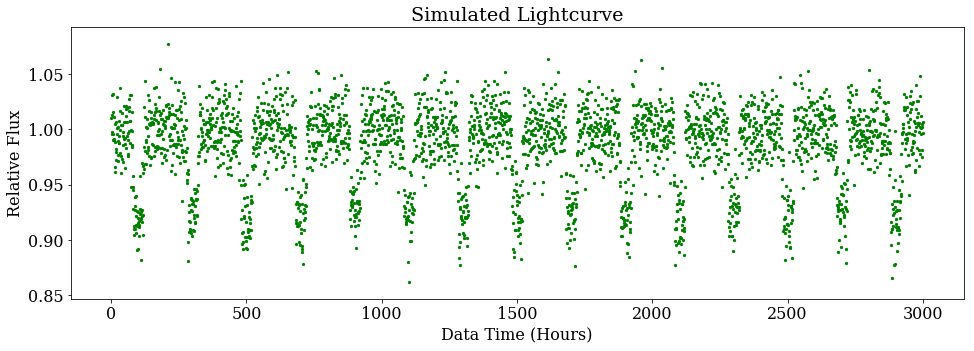

In [186]:
fig = plt.figure(figsize=(16, 5))
np.random.seed(42)
example_time = np.linspace(1, 3000, 3000)
example_flux = np.ones(200)
example_flux[80:120] = 0.92
example_flux = ndimage.gaussian_filter(example_flux, sigma=2)
example_flux = np.tile(example_flux, 15)
example_flux = example_flux + np.random.randn(len(example_flux)) * 0.02
plt.scatter(example_time, example_flux, color='green', s=5)
plt.xlabel('Data Time (Hours)')
plt.ylabel('Relative Flux')
plt.title('Simulated Lightcurve')

#### However, sometimes the Sun will block the view of a telescope, the telescope needs to reposition, there might be a malfunction or an observing break is necessary, and we cannot view the same object every single hour. Also, to survey lots of stars, sometimes telescopes point to various areas of the sky, and then come back to areas it previously visited. In reality, we only get to look at the star every several hours, or we look at the star constantly for a day and come back to it a week later. Data might also get corrupted when it is transmitted to Earth. A more realistic picture of data looks like the below plot:

In [187]:
sample = (np.random.rand(400) * 3000).astype(int)
s_x, s_y = example_time[sample], example_flux[sample]

In [200]:
fig = plt.figure(figsize=(16, 5))
plt.scatter(s_x, s_y, color='green', s=5)
plt.xlabel('Data Time (Hours)')
plt.ylabel('Relative Flux')

#### Okay, so there are clearly some points lower than the others, but the signal is far less clear; and if there is a transit, it is not clear how deep the dip goes. Now we can use the power of 'Folding' the data over the 200 hour period, combining the signal over many full orbits. This is equivalent to plotting the data using 'Clock Time,' where our clock runs for 200 hours before it repeats. Press play in the beow plot to see an animation:

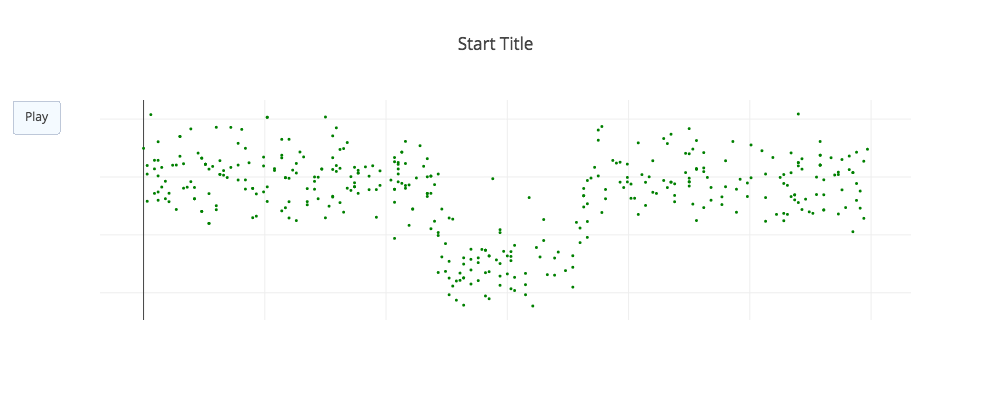

In [190]:
figure = {'data': [{'x': s_x, 'y': s_y, 'mode': 'markers',
          'marker': {'sizemode': 'area','size': 3,'color': 'green'},}],
          'layout': {# 'xaxis': {'range': [0, 5], 'autorange': False},
                     # 'yaxis': {'range': [0, 5], 'autorange': False},
                     'xaxis' : {'showticklabels' : False},
                     'yaxis' : {'showticklabels' : False},
                     'title': 'Folding a Lightcurve Time-Series',
                     'updatemenus': [{'type': 'buttons',
                                      'buttons': [{'label': 'Play',
                                                   'method': 'animate',
                                                   'args': [None, dict(frame=dict(duration=2000, redraw=True),
                                                           transition=dict(duration=1500),)]}]}],
                    'width' : 1000, 'height' : 400},
          'frames': [
                     {'data': [{'x': (s_x % 200) * 15, 'y': s_y, 'mode': 'markers',
          'marker': {'sizemode': 'area','size': 3,'color': 'green'},}]},
                     {'data': [{'x': s_x, 'y': s_y, 'mode': 'markers',
          'marker': {'sizemode': 'area','size': 3,'color': 'green'},}]},
                     {'data': [{'x': (s_x % 200) * 15, 'y': s_y, 'mode': 'markers',
          'marker': {'sizemode': 'area','size': 3,'color': 'green'},}]},
                     {'data': [{'x': s_x, 'y': s_y, 'mode': 'markers',
          'marker': {'sizemode': 'area','size': 3,'color': 'green'},}]},
                     {'data': [{'x': (s_x % 200) * 15, 'y': s_y, 'mode': 'markers',
          'marker': {'sizemode': 'area','size': 3,'color': 'green'},}]},
                     {'data': [{'x': s_x, 'y': s_y, 'mode': 'markers',
          'marker': {'sizemode': 'area','size': 3,'color': 'green'},}]},
                     {'layout': {'title': 'Folding a Lightcurve Time-Series'}}
          ]}

iplot(figure)

#### You should be able to see the data clearly align into a single 'dip'. This is precisely how one detects transit events using photometry, which reveals the presence of an exoplanet.

#### We made a huge assumption in this process. We told you ahead of time that the planet has an orbit of 200 days, since we used this period to create the mock dataset. In reality, scientists have to guess lots of orbital periods, with an precision of several minutes. There are some mathematical tricks to help with this. You might have heard of Fourier Analysis at some point, which pertains to finding the periods of repeating signals in data. However, the details are beyond the scope of this course. 

#### The precision here is exceptionally important. Imagine a normal clock that runs a bit fast; it gains a minute every 24 hours. It will tell you the time fairly well for the first several days, but after a couple months, you will be an hour off. And this continues to grow until your clock is useless.

## *Question 4*

#### Do you think it is easier to detect planets with short periods or long periods, and why?

In [241]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

## *Question 5*

#### Let's pretend that we did not know the period of the above planet, and that we guessed it has a period of 400 days. What would the folded lightcurve look like (qualitatively)?

In [240]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

# Section 4: Real Transit Data

#### In the below plots, you will see real lightcurve data from observations of a mystery star:

(0.999, 1.001)

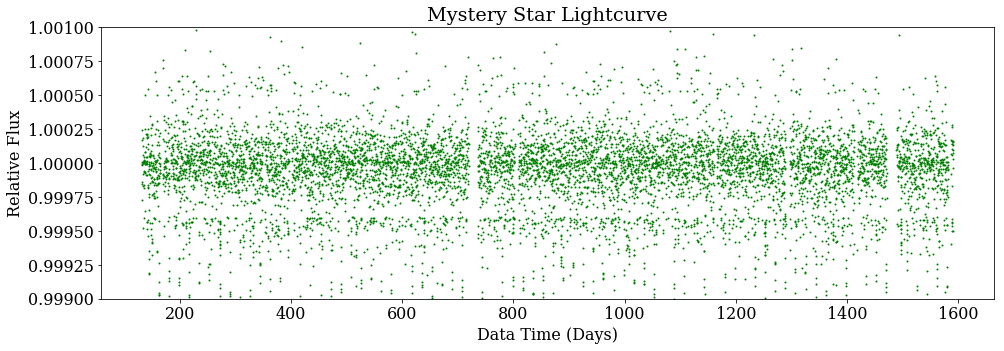

In [201]:
fig = plt.figure(figsize=(16, 5))
plt.scatter(t, l + 1, color='Green', s=1)
plt.xlabel('Data Time (Days)')
plt.ylabel('Relative Flux')
plt.title('Mystery Star Lightcurve')
plt.ylim(0.999, 1.001)

#### Do you see any transits? Can you estimate the period of the orbit, or the depth of the transit from the above plot? Maybe you could if you were very careful, but it would be more useful to convert the above into a Folded Time-Series. To do this, we need to guess the period of the exoplanet, and then convert the Data Time into a new Clock Time, where our clock repeats every period. Try using the slider at the bottom of the next plot*, to see what happens when we guess the period of the exoplanet: 
##### * Note: we have 'averaged' some of the data together for interactivity and clarity

In [202]:
periods = np.array([2.345, 5.71493, 12.4417, 15.345, 18.16406, 50.928, 122.3874, 101.306, 267.291, 365.256])
window = 6
lcdata = []

for p in periods:
    x = (t % p) / p
    y = l + 1
    idx = x.argsort()
    x = x[idx]
    y = y[idx]
    x = np.array([np.mean(x[k:k+window]) for k in np.arange(0, len(x), window)])
    y = np.array([np.mean(y[k:k+window]) for k in np.arange(0, len(y), window)])
    lcdata.append((x,y))

n = len(periods)

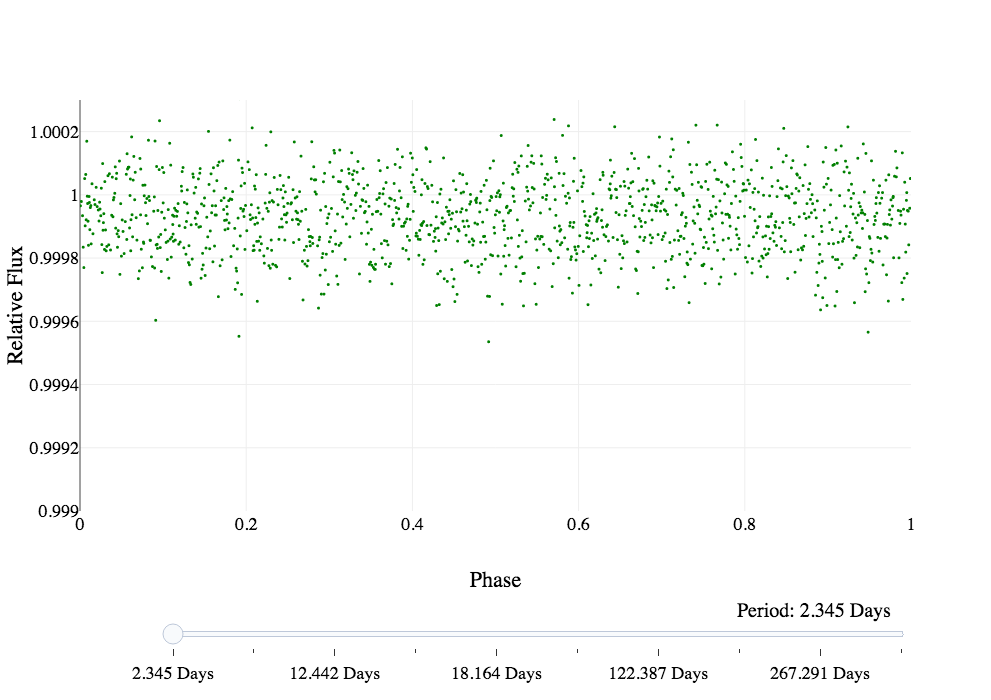

In [204]:
# Interactive Animation
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['xaxis'] = {'range': [0, 1], 'title': 'Phase'}
figure['layout']['yaxis'] = {'title': 'Relative Flux', 'range': [1 - 0.001, 1 + 0.0003]}
figure['layout']['hovermode'] = 'closest'

sliders_dict = {'active': 0, 'yanchor': 'top', 'xanchor': 'left',
    'currentvalue': {'font': {'size': 20},'prefix': 'Period: ','visible': True,'xanchor': 'right'},
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 80}, 'len': 0.9, 'x': 0.1,'y': 0, 'steps': []
}

data_dict = {
    'x': list(lcdata[0][0]), 'y': list(lcdata[0][1]), 'mode': 'markers',
    'marker': {'sizemode': 'area','size': 4},}
figure['data'].append(data_dict)
    
# make frames
for k in range(n):
    period = periods[k]
    frame = {'data': [], 'name': str(np.round(period, 3)) + ' Days'}
    dataset = lcdata[k]

    data_dict = {'x': dataset[0],'y': dataset[1],'mode': 'markers',
        'marker': {'sizemode': 'area','size': 3,'color': 'green'},}
    frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [str(np.round(period, 3)) + ' Days'], {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate','transition': {'duration': 300}}],
         'label': str(np.round(periods[k], 3)) + ' Days',
         'method': 'animate'}
    sliders_dict['steps'].append(slider_step)
    
figure['layout']['sliders'] = [sliders_dict]
figure['layout']['font'] = dict(family='Droid Serif', size=18, color='black')
figure['layout']['autosize'] = False
figure['layout']['width'] = 1000
figure['layout']['height'] = 700
iplot(figure)

## *Question 6*

#### For which periods do you see a transit signal? What are the transit depths (distance in Relative Flux to the bottom of the dip)? Hint: there are transits for five of the above options, but try to find at least two.

In [239]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

#### What does it mean if you find a transit signal at multiple guesses of the period? It means multiple planets! Indeed, this is a multi-planet system.

#### Here we plot the entire dataset, for a period of about 267 days. See if you can spot the transit (hint: the signal has been folded such that the dip is right next to Phase of 0.2):
##### *Drag the Mouse on the plot to Zoom-in, and Double Click on the plot to Zoom-out

In [207]:
def getLayout():
    
    layout = dict(
        autosize=False,
        width=1000,
        height=700,
        font=dict(family='Droid Serif', size=18, color='black'),
        yaxis = dict(title='Relative Flux',
                    tickvals = np.linspace(1 - 0.0015, 1 + 0.0015, 31),
                    showticklabels = True, range=[1 - 0.0007, 1 + 0.0003],automargin=True,),
        title='Mystery Star Folded Light Curve',
        xaxis=dict(title='Time (Days)',
                    rangeselector=dict(buttons=list([dict(step='all', label='Full',visible=False)])),
                    rangeslider=dict(visible = False),
                    automargin=True,),
        hovermode = 'closest', showlegend = False,)
    
    return layout

def getData(time, lc, P, window):
    
    x = (time % P) / P
    y = lc + 1
    idx = x.argsort()
    x = x[idx]
    y = y[idx]
    x = np.array([np.mean(x[k:k+window]) for k in np.arange(0, len(x), window)])
    y = np.array([np.mean(y[k:k+window]) for k in np.arange(0, len(y), window)])

    trace = go.Scattergl(
        x=x, y=y, mode = 'markers', marker = dict(
            symbol = 'circle', color = 'green', size = 3, line = None))
    
    return trace

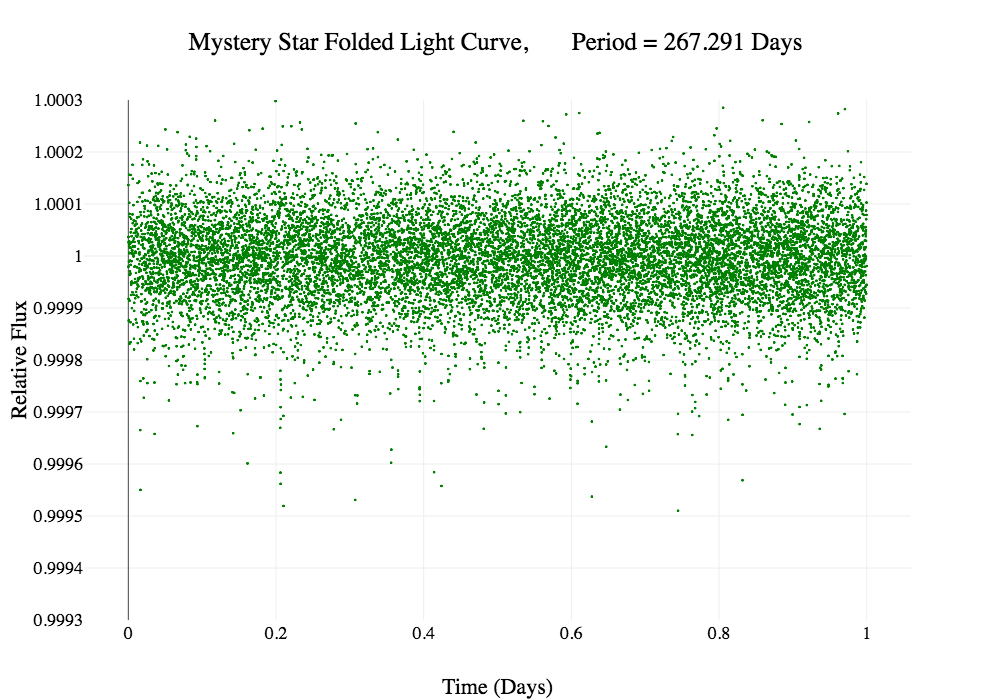

In [213]:
P = 267.291 
data = [getData(time, lc, P, 5)]
layout = getLayout()
layout['title']=layout['title']+',       Period = '+str(np.round(P, 4)) + ' Days'

fig = dict(data=data, layout=layout)
iplot(fig)

## *Question 7*

#### The above transit has a period of 267.291 Days, and a transit depth of about 0.0004. The (mystery) host star has a mass of $0.69 M_{\odot}$ and $0.63 R_{\odot}$. What is the distance of the planet from its host star (use Kepler's Law)?

In [238]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

## *Question 8*

#### What is the radius of the planet *in Earth Radii*?

In [237]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

# Section 5: Another Solar System

#### Proceed to the following link:

In [211]:
print("http://exoplanet.eu/diagrams/")

http://exoplanet.eu/diagrams/


#### This is a plot of all know exoplanets, with estimated mass on the x-axis, and orbital period on the y-axis. On the right hand side, you will see a panel where you can change the limits of the plot. Look for "Y axis" and then underneath it you will see fields labeled "min" and "max." Find the planet with a period of 267.291 by entering a "min" of 267 and a "max of 268. Press enter. You should see one data point in the plot. Click on it.

## *Question 9*

#### What is the name of the Planet? If this planet is the furthest out in the star system and the most recent one found, how many planets are in this system? (hint: the naming convention starts with b for the first planet)

In [236]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

#### Now, open the following journal paper in your browser:

In [214]:
print("https://arxiv.org/pdf/1304.7387.pdf")

https://arxiv.org/pdf/1304.7387.pdf


#### Read the Abstract on Page 2, and look at Figure 1 on Page 3. Feel free to read more if you wish.

## *Question 10*

#### What is the significance of this particular solar system?

In [235]:
HTML('''
<textarea rows="10" cols="50" style="font-size:14pt;" placeholder="Answer...">
</textarea>
''')

#### The results which you have reproduced in this homework exercise were published in the journal *Science* in 2013. The significant discovery of this exoplanetary system also received substantial news coverage. Feel free to read the below article at your leisure.

In [215]:
print("https://www.nytimes.com/2013/04/19/science/space/2-new-planets-are-most-earth-like-yet-scientists-say.html")

https://www.nytimes.com/2013/04/19/science/space/2-new-planets-are-most-earth-like-yet-scientists-say.html


In [218]:
HTML('''
<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter.
</footer>
''')